In [ ]:

# Standard Libraries
import pandas as pd
import numpy as np
import json

# Data Preprocessing & NLP
import nltk
import re
import string
import gensim
from textblob import Word

import xgboost as xgb
from xgboost import XGBClassifier

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')

# Models
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.svm import SVC, LinearSVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor, GradientBoostingClassifier,BaggingClassifier
# from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics.pairwise import linear_kernel

# Performance metrics
# from sklearn.metrics import confusion_matrix, f1_score
# from sklearn.model_selection import cross_val_score, KFold
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, make_scorer, roc_curve, roc_auc_score
# from sklearn.metrics import precision_recall_fscore_support as score
# from sklearn.metrics.pairwise import cosine_similarity

# Visualization Libraries
import matplotlib.pyplot as plt
# import seaborn as sns
# from PIL import Image
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
import tensorflow as tf
layers = keras.layers
models = keras.models
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras.layers import Flatten

np.random.seed(1001)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

---




In [ ]:
news_df = pd.read_csv("/content/drive/MyDrive/Data/A4/TrainData.csv")
news_df['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(np.array(news_df["Category"]).reshape(-1,1))
y_train = enc.transform(np.array(news_df["Category"]).reshape(-1,1)).toarray()
y_train[0]

array([1., 0., 0., 0., 0.])

In [ ]:
!pip install contractions

     |████████████████████████████████| 284 kB 5.1 MB/s 
     |████████████████████████████████| 321 kB 48.1 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85453 sha256=3e3595848bb22bfaa3ac8147d7e56e28e7950a7bb217c0eddb1d8f3f3d682555
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
import contractions
# Data Cleaning
def clean_text(text):
    clean_texts = ""
    expanded_words = ""
    # remove everything except alphabets
    # text = re.sub("[^a-zA-Z]", " ", text)

    words = text.split(" ")

    for word in words:
      word = contractions.fix(word)
      tokens = word.split(" ")
      for token in tokens:
        if(len(token) > 1):
          expanded_words = expanded_words + ' ' + token  
    clean_texts = clean_texts + ' ' + expanded_words
    # remove whitespaces
    clean_texts = ' '.join(clean_texts.split())
    clean_texts = clean_texts.lower()
    
    return clean_texts

In [ ]:

# creating clean text feature
news_df['clean_text'] = news_df['Text'].apply(clean_text)

In [ ]:
X = news_df.loc[:,'clean_text']

In [ ]:
max_seq_length = max([len(text.split(" ")) for text in X])
avg_seq_length = np.mean([len(text.split(" ")) for text in X])
print("max_seq_length = " , max_seq_length)
print("avg_seq_length = " , avg_seq_length)
print(X[0])

max_seq_length =  3165
avg_seq_length =  367.7281879194631
worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against battery of fraud charges have called company whistleblower as their first witness. cynthia cooper worldcom ex-head of internal accounting alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy. prosecution lawyers have argued that mr ebbers orchestrated series of accounting tricks at worldcom ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper who now runs her own consulting business told jury in new york on wednesday that external auditors arthur andersen had approved worldcom accounting in early 2001 and 2002. she said andersen had given green light to the procedures and

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words =  1000 #3000

tokenizer = Tokenizer(oov_token = "OOV")
tokenizer.fit_on_texts(X)

sequence_train = tokenizer.texts_to_sequences(X)
sequence_train = pad_sequences(sequence_train,padding='post', maxlen=max_words)
x_train = np.asarray(sequence_train)

# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

x_train shape: (1490, 1000)
y_train shape: (1490, 5)


In [ ]:
news_test_df = pd.read_csv("/content/drive/MyDrive/Data/A4/TestData_Inputs.csv")
news_test_df2 = pd.read_excel("/content/drive/MyDrive/Data/A4/Assignment4_TestLabels.xlsx")
# creating clean text feature

news_test_df['clean_text'] = news_test_df['Text'].apply(clean_text)
# news_test_df['clean_text'] = news_test_df['clean_text'].apply(lambda x: remove_stopwords(x))
X_test = news_test_df.loc[:,'clean_text']

y_test = enc.transform(np.array(news_test_df2['Label - (business, tech, politics, sport, entertainment)']).reshape(-1,1)).toarray()

sequence_test = tokenizer.texts_to_sequences(X_test)
sequence_test = pad_sequences(sequence_test,padding='post', maxlen=max_words)
X_test = np.asarray(sequence_test)

# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
news_test_df.head()

x_test shape: (735, 1000)
y_test shape: (735, 5)


,ArticleId,Text,clean_text
0,1018,qpr keeper day heads for preston queens park r...,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...,arcy injury adds to ireland woe gordon arcy ha...
3,459,india s reliance family feud heats up the ongo...,india reliance family feud heats up the ongoin...
4,1020,boro suffer morrison injury blow middlesbrough...,boro suffer morrison injury blow middlesbrough...


In [ ]:
dict(list((tokenizer.word_index).items())[0:10])


{'OOV': 1,
 'and': 5,
 'for': 7,
 'in': 6,
 'is': 8,
 'it': 10,
 'of': 4,
 'that': 9,
 'the': 2,
 'to': 3}

In [ ]:
# embedding_matrix_w2v = np.load("/content/drive/MyDrive/Data/A4/A4_matrix_w2v2.npy")
# embedding_matrix_ft = np.load("/content/drive/MyDrive/Data/A4/A4_matrix_ft2.npy")
# embedding_matrix_glove = np.load("/content/drive/MyDrive/Data/A4/A4_matrix_glove2.npy")

# Positional Encoding
A vector added to the embedding to encode positional information

https://www.tensorflow.org/tutorials/text/transformer#positional_encoding

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

## Multi Headed Attention

Test of multi-headed Attention    
Shape = (batch_size , num_heads, seq_length, depth)

For each of [query, value, key]   
we reshape from  (batch_size , seq_length, depth) ->  (batch_size , seq_length, num_heads, multi_headed_depth)   
then permute  ->  (batch_size , num_heads, seq_length, multi_headed_depth)  
where multi-headed_depth = depth / num_heads

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model = 512, num_heads = 8, causal=False, dropout=0.0):
    super(MultiHeadAttention, self).__init__()

    assert d_model % num_heads == 0
    depth = d_model // num_heads

    self.w_query = tf.keras.layers.Dense(d_model)
    self.split_reshape_query = tf.keras.layers.Reshape((-1,num_heads,depth))  
    self.split_permute_query = tf.keras.layers.Permute((2,1,3))      

    self.w_value = tf.keras.layers.Dense(d_model)
    self.split_reshape_value = tf.keras.layers.Reshape((-1,num_heads,depth))
    self.split_permute_value = tf.keras.layers.Permute((2,1,3))

    self.w_key = tf.keras.layers.Dense(d_model)
    self.split_reshape_key = tf.keras.layers.Reshape((-1,num_heads,depth))
    self.split_permute_key = tf.keras.layers.Permute((2,1,3))

    self.attention = tf.keras.layers.Attention(causal=causal, dropout=dropout)
    self.join_permute_attention = tf.keras.layers.Permute((2,1,3))
    self.join_reshape_attention = tf.keras.layers.Reshape((-1,d_model))

    self.dense = tf.keras.layers.Dense(d_model)

  def call(self, inputs, mask=None, training=None):
    q = inputs[0]
    v = inputs[1]
    k = inputs[2] if len(inputs) > 2 else v

    query = self.w_query(q)
    query = self.split_reshape_query(query)    
    query = self.split_permute_query(query)                 

    value = self.w_value(v)
    value = self.split_reshape_value(value)
    value = self.split_permute_value(value)

    key = self.w_key(k)
    key = self.split_reshape_key(key)
    key = self.split_permute_key(key)

    if mask is not None:
      if mask[0] is not None:
        mask[0] = tf.keras.layers.Reshape((-1,1))(mask[0])
        mask[0] = tf.keras.layers.Permute((2,1))(mask[0])
      if mask[1] is not None:
        mask[1] = tf.keras.layers.Reshape((-1,1))(mask[1])
        mask[1] = tf.keras.layers.Permute((2,1))(mask[1])

    attention = self.attention([query, value, key], mask=mask)
    attention = self.join_permute_attention(attention)
    attention = self.join_reshape_attention(attention)

    x = self.dense(attention)

    return x

## Encoder Layers

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,  d_model = 512, num_heads = 8, dff = 2048, dropout = 0.0):
    super(EncoderLayer, self).__init__()

    self.multi_head_attention =  MultiHeadAttention(d_model, num_heads)
    self.dropout_attention = tf.keras.layers.Dropout(dropout)
    self.add_attention = tf.keras.layers.Add()
    self.layer_norm_attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')
    self.dense2 = tf.keras.layers.Dense(d_model)
    self.dropout_dense = tf.keras.layers.Dropout(dropout)
    self.add_dense = tf.keras.layers.Add()
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def call(self, inputs, mask=None, training=None):
    # print(mask)
    attention = self.multi_head_attention([inputs,inputs,inputs], mask = [mask,mask])
    attention = self.dropout_attention(attention, training = training)
    x = self.add_attention([inputs , attention])
    x = self.layer_norm_attention(x)
    # x = inputs

    ## Feed Forward
    dense = self.dense1(x)
    dense = self.dense2(dense)
    dense = self.dropout_dense(dense, training = training)
    x = self.add_dense([x , dense])
    x = self.layer_norm_dense(x)

    return x


the causal = True argument for multi_head_attention1 automatically masks  future tokens in the sequence

## Encoder Blocks



In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, num_layers = 4, d_model = 512, num_heads = 8, dff = 2048, maximum_position_encoding = 10000, dropout = 0.0):
    super(Encoder, self).__init__()

    self.d_model = d_model

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model, mask_zero=True)
    self.pos = positional_encoding(maximum_position_encoding, d_model)

    self.encoder_layers = [ EncoderLayer(d_model = d_model, num_heads = num_heads, dff = dff, dropout = dropout) for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(dropout)

  def call(self, inputs, mask=None, training=None):
    x = self.embedding(inputs)
    # positional encoding
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # scaling by the sqrt of d_model, not sure why or if needed??
    x += self.pos[: , :tf.shape(x)[1], :]

    x = self.dropout(x, training=training)

    #Encoder layer
    embedding_mask = self.embedding.compute_mask(inputs)
    for encoder_layer in self.encoder_layers:
      x = encoder_layer(x, mask = embedding_mask)

    return x

  def compute_mask(self, inputs, mask=None):
    return self.embedding.compute_mask(inputs)

# Transformer model

In [ ]:
num_layers = 2
d_model = 64
dff = 256
num_heads = 8
dropout_rate = 0.4
MAX_LENGTH = max_words

input_vocab_size = len(tokenizer.index_word) + 1


input = tf.keras.layers.Input(shape=(MAX_LENGTH,))
encoder = Encoder(input_vocab_size, num_layers = num_layers, d_model = d_model, num_heads = num_heads,
                  dff = dff, dropout = dropout_rate)

x = encoder(input)
x = Bidirectional(GRU(128, dropout=0.2))(x)
output = Dense(5, activation='sigmoid')(x)
# flatten = Flatten()(x)
# dense1 = Dense(256, activation="relu")(flatten)
# dropout = Dropout(0.2)(dense1)
# output = Dense(5, activation="sigmoid")(dropout)
  
model = Model(input, output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
encoder_2 (Encoder)          (None, 1000, 64)          1697984   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               148992    
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 1285      
Total params: 1,848,261
Trainable params: 1,848,261
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min' ,patience=6)
history = model.fit(x_train , y_train,
                    batch_size=16,
                    epochs=15,
                    verbose=2,
                    callbacks=[callback],
                    validation_split=0.2)

Epoch 1/15
75/75 - 57s - loss: 1.5850 - accuracy: 0.3029 - val_loss: 1.4928 - val_accuracy: 0.3758
Epoch 2/15
75/75 - 37s - loss: 1.4095 - accuracy: 0.4027 - val_loss: 1.4187 - val_accuracy: 0.4228
Epoch 3/15
75/75 - 38s - loss: 0.9551 - accuracy: 0.6376 - val_loss: 0.5451 - val_accuracy: 0.8087
Epoch 4/15
75/75 - 38s - loss: 0.3324 - accuracy: 0.8859 - val_loss: 0.3119 - val_accuracy: 0.9128
Epoch 5/15
75/75 - 37s - loss: 0.1210 - accuracy: 0.9648 - val_loss: 0.2323 - val_accuracy: 0.9497
Epoch 6/15
75/75 - 37s - loss: 0.0779 - accuracy: 0.9765 - val_loss: 0.4026 - val_accuracy: 0.9329
Epoch 7/15
75/75 - 38s - loss: 0.0297 - accuracy: 0.9891 - val_loss: 0.2810 - val_accuracy: 0.9530
Epoch 8/15
75/75 - 38s - loss: 0.0244 - accuracy: 0.9899 - val_loss: 0.3461 - val_accuracy: 0.9430
Epoch 9/15
75/75 - 38s - loss: 0.0157 - accuracy: 0.9958 - val_loss: 0.3154 - val_accuracy: 0.9497
Epoch 10/15
75/75 - 37s - loss: 0.0176 - accuracy: 0.9941 - val_loss: 0.2980 - val_accuracy: 0.9631
Epoch 11/

In [ ]:
tf.keras.models.save_model(model, "/content/drive/MyDrive/Data/Teacher_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/Teacher_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/Teacher_model/assets


In [ ]:
model = models.load_model("/content/drive/MyDrive/Data/Teacher_model")

In [ ]:
score, acc = model.evaluate(X_test, y_test)

23/23 [==============================] - 0s 21ms/step - loss: 0.1708 - accuracy: 0.9687


In [ ]:
y_pred = model.predict(X_test, verbose=1)
y_pred

23/23 [==============================] - 83s 4s/step


array([[0.18583602, 0.79918766, 0.03613126, 0.9517698 , 0.2932196 ],
       [0.02059722, 0.12356031, 0.26470768, 0.0662531 , 0.9995574 ],
       [0.37572888, 0.6301184 , 0.01341802, 0.9522482 , 0.36330637],
       ...,
       [0.50982744, 0.47725064, 0.01549059, 0.1341717 , 0.90328515],
       [0.98368585, 0.5460714 , 0.05245233, 0.03031901, 0.1893548 ],
       [0.01286665, 0.6675741 , 0.9994266 , 0.00939959, 0.65503454]],
      dtype=float32)

In [ ]:
y_pred.shape

(735, 5)

In [ ]:
num_layers = 1
d_model = 64
dff = 128
num_heads = 4
dropout_rate = 0.4
MAX_LENGTH = max_words

input_vocab_size = len(tokenizer.index_word) + 1


input = tf.keras.layers.Input(shape=(MAX_LENGTH,))
encoder = Encoder(input_vocab_size, num_layers = num_layers, d_model = d_model, num_heads = num_heads,
                  dff = dff, dropout = dropout_rate)

x = encoder(input)
x = Bidirectional(GRU(64, dropout=0.2))(x)
output = Dense(5, activation='sigmoid')(x)
# flatten = Flatten()(x)
# dense1 = Dense(256, activation="relu")(flatten)
# dropout = Dropout(0.2)(dense1)
# output = Dense(5, activation="sigmoid")(dropout)
  
model = Model(input, output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min' ,patience=6)
history = model.fit(x_train , y_train,
                    batch_size=16,
                    epochs=15,
                    verbose=2,
                    callbacks=[callback],
                    validation_split=0.2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
encoder_3 (Encoder)          (None, 1000, 64)          1631488   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               49920     
_________________________________________________________________
dense_36 (Dense)             (None, 5)                 645       
Total params: 1,682,053
Trainable params: 1,682,053
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
75/75 - 33s - loss: 1.5982 - accuracy: 0.2718 - val_loss: 1.5792 - val_accuracy: 0.3356
Epoch 2/15
75/75 - 19s - loss: 1.4372 - accuracy: 0.3851 - val_loss: 1.3714 - val_accuracy: 0.4362
Epoch 3/15
75/75 - 20s - loss: 1.1363 - accuracy:

In [ ]:
tf.keras.models.save_model(model, "/content/drive/MyDrive/Data/weak_student_model")


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/weak_student_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/weak_student_model/assets


In [ ]:
score, acc = model.evaluate(X_test, y_test)

23/23 [==============================] - 3s 145ms/step - loss: 0.2738 - accuracy: 0.9456


In [ ]:
num_layers = 1
# d_model = 128
dff = 256
num_heads = 8
dropout_rate = 0.3

BATCH_SIZE = 64
MAX_LENGTH = max_words

input_vocab_size = len(tokenizer.index_word) + 1
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min' ,patience=7)

def fitmodel1(dim_model):
  for d_model in dim_model:
    print("progress : ", d_model/64)
    input = tf.keras.layers.Input(shape=(MAX_LENGTH,))
    encoder = Encoder(input_vocab_size, num_layers = num_layers, d_model = d_model, num_heads = num_heads,
                      dff = dff, dropout = dropout_rate)
    x = encoder(input)
    x = Bidirectional(GRU(128, dropout=0.2))(x)
    output = Dense(5, activation='sigmoid')(x) 
    model = Model(input, output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train , y_train,
                        batch_size=32,
                        epochs=8,
                        verbose=0,
                        callbacks=[callback],
                        validation_split=0.2)
    plt.title('Loss Vs Epochs ' )
    plt.plot(history.history['val_loss'],label="d_model : "+str(d_model))
    plt.legend()

progress :  1.0
progress :  2.0
progress :  4.0
progress :  8.0


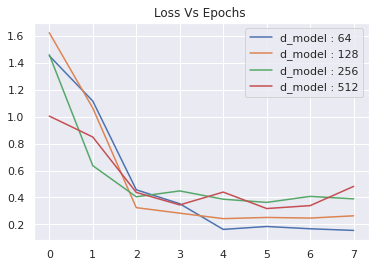

In [ ]:
dim_model = [64 , 128 , 256 , 512]
fitmodel1(dim_model)

In [ ]:
num_layers = 1
d_model = 64
dff = 256
# num_heads = 8
dropout_rate = 0.3

MAX_LENGTH = max_words

input_vocab_size = len(tokenizer.index_word) + 1
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min' ,patience=7)

def fitmodel2(num_heads_arr):
  for num_heads in num_heads_arr:
    print("progress : ", num_heads/8)
    input = tf.keras.layers.Input(shape=(MAX_LENGTH,))
    encoder = Encoder(input_vocab_size, num_layers = num_layers, d_model = d_model, num_heads = num_heads,
                      dff = dff, dropout = dropout_rate)
    x = encoder(input)
    x = Bidirectional(GRU(128, dropout=0.2))(x)
    output = Dense(5, activation='sigmoid')(x) 
    model = Model(input, output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train , y_train,
                        batch_size=32,
                        epochs=10,
                        verbose=0,
                        callbacks=[callback],
                        validation_split=0.2)
    plt.title('Loss Vs Epochs ' )
    plt.plot(history.history['val_loss'],label="num_heads : "+str(num_heads))
    plt.legend()

progress :  1.0
progress :  2.0
progress :  4.0


ResourceExhaustedError: ignored

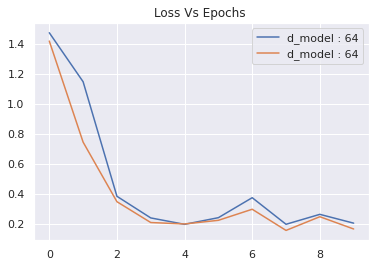

In [ ]:
num_heads_arr = [8 , 16 ]
fitmodel2(num_heads_arr)

In [ ]:
# num_layers = 1
d_model = 64
dff = 256
num_heads = 8
dropout_rate = 0.3

MAX_LENGTH = max_words

input_vocab_size = len(tokenizer.index_word) + 1
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min' ,patience=7)

def fitmodel2(num_layers_arr):
  for num_layers in num_layers_arr:
    print("progress : ", num_layers)
    input = tf.keras.layers.Input(shape=(MAX_LENGTH,))
    encoder = Encoder(input_vocab_size, num_layers = num_layers, d_model = d_model, num_heads = num_heads,
                      dff = dff, dropout = dropout_rate)
    x = encoder(input)
    x = Bidirectional(GRU(128, dropout=0.2))(x)
    output = Dense(5, activation='sigmoid')(x) 
    model = Model(input, output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train , y_train,
                        batch_size=32,
                        epochs=12,
                        verbose=0,
                        callbacks=[callback],
                        validation_split=0.2)
    plt.title('Loss Vs Epochs ' )
    plt.plot(history.history['val_loss'],label="num_layers : "+str(num_layers))
    plt.legend()

progress :  1
progress :  2
progress :  3


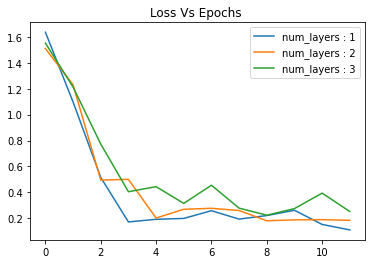

In [ ]:
num_layers_arr = [1 , 2 , 3]
fitmodel2(num_layers_arr)

In [ ]:
num_layers = 1
d_model = 64
dff = 256
num_heads = 8
dropout_rate = 0.3

MAX_LENGTH = max_words

input_vocab_size = len(tokenizer.index_word) + 1
input = tf.keras.layers.Input(shape=(MAX_LENGTH,))
encoder = Encoder(input_vocab_size, num_layers = num_layers, d_model = d_model, num_heads = num_heads,
                  dff = dff, dropout = dropout_rate)

x = encoder(input)
x = Bidirectional(LSTM(512, dropout=0.2, return_sequences = True))(x)
x = Bidirectional(LSTM(128, dropout=0.2))(x)
output = Dense(5, activation='sigmoid')(x)
  
model = Model(input, output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
encoder (Encoder)            (None, 1000, 64)          1648000   
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 1024)        2363392   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               1180672   
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 1285      
Total params: 5,193,349
Trainable params: 5,193,349
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min' ,patience=4)
history = model.fit(x_train , y_train,
                    batch_size=16,
                    epochs=2,
                    verbose=2,
                    callbacks=[callback],
                    validation_split=0.2)

Epoch 1/2


In [ ]:
score, acc = model.evaluate(X_test, y_test)

23/23 [==============================] - 11s 480ms/step - loss: 0.2046 - accuracy: 0.9578


In [ ]:
num_layers = 1
d_model = 64
dff = 256
num_heads = 8
dropout_rate = 0.5

MAX_LENGTH = max_words

input_vocab_size = len(tokenizer.index_word) + 1
print("input vocab size : " , input_vocab_size)
input = tf.keras.layers.Input(shape=(MAX_LENGTH,))
encoder = Encoder(input_vocab_size, num_layers = num_layers, d_model = d_model, num_heads = num_heads,
                  dff = dff, dropout = dropout_rate)

x = encoder(input)
x = Bidirectional(LSTM(128, dropout=0.2))(x)
output = Dense(5, activation='sigmoid')(x)
  
model = Model(input, output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

input vocab size :  24969
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 1000)]            0         
_________________________________________________________________
encoder_2 (Encoder)          (None, 1000, 64)          1648000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_60 (Dense)             (None, 5)                 1285      
Total params: 1,846,917
Trainable params: 1,846,917
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min' ,patience=4)
history = model.fit(x_train , y_train,
                    batch_size=16,
                    epochs=10,
                    verbose=2,
                    callbacks=[callback],
                    validation_split=0.2)

Epoch 1/10
75/75 - 221s - loss: 1.5429 - accuracy: 0.2945 - val_loss: 1.5360 - val_accuracy: 0.3859
Epoch 2/10
75/75 - 211s - loss: 1.2314 - accuracy: 0.4841 - val_loss: 0.9109 - val_accuracy: 0.6309
Epoch 3/10
75/75 - 209s - loss: 0.6985 - accuracy: 0.7156 - val_loss: 0.4846 - val_accuracy: 0.8423
Epoch 4/10
75/75 - 209s - loss: 0.3600 - accuracy: 0.8691 - val_loss: 0.2910 - val_accuracy: 0.9128
Epoch 5/10
75/75 - 208s - loss: 0.1278 - accuracy: 0.9597 - val_loss: 0.2434 - val_accuracy: 0.9329
Epoch 6/10
75/75 - 209s - loss: 0.0881 - accuracy: 0.9732 - val_loss: 0.2232 - val_accuracy: 0.9161
Epoch 7/10
75/75 - 213s - loss: 0.0775 - accuracy: 0.9757 - val_loss: 0.2980 - val_accuracy: 0.9128
Epoch 8/10
75/75 - 212s - loss: 0.0254 - accuracy: 0.9916 - val_loss: 0.2217 - val_accuracy: 0.9396
Epoch 9/10
75/75 - 211s - loss: 0.0605 - accuracy: 0.9782 - val_loss: 0.2000 - val_accuracy: 0.9228
Epoch 10/10
75/75 - 215s - loss: 0.0587 - accuracy: 0.9815 - val_loss: 0.2120 - val_accuracy: 0.9664

In [ ]:
score, acc = model.evaluate(X_test, y_test)

23/23 [==============================] - 28s 1s/step - loss: 0.2469 - accuracy: 0.9497
